# Tutorial 2 - NN Architectures

In this tutorial, you will implement a CNN to classify hand-written digits.

In [1]:
# NN packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# Optimizers
import torch.optim as optim

# Loading data
from torch.utils.data import TensorDataset, DataLoader

# Other packages for plotting and data maipulation
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set random seed for reproducibility
torch.manual_seed(17)

# Detect CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


## 1. Obtain the dataset

We need a dataset. We use the MNIST dataset of hand-written digits, which is almost too simple to be a good check for anything. But since it is so simple, we can get great results with very limited resources. The set is completely standard and can be obtained from many sources, since it served as a benchmark dataset in the old days. We download it with torch. 

In [23]:
import torchvision

train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True
)

train_data, train_labels = train_dataset.data, train_dataset.targets

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True
)
test_data, test_labels = test_dataset.data, test_dataset.targets

# we have 60k train and 10k test images. They are 28 x 28
print(train_data.shape, test_data.shape)

# check that the corresponding labels match
print(train_labels.shape, test_labels.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


Usually we would have to perform a train-test-split ourselves, but for this standard dataset, this has already been done...

## 2. Investigate the Dataset

In [4]:
# look at a single example as raw data. We can see that it is a 5, but we can also plot this more nicely.
for row in train_data[0]:
    print(row.tolist())
train_labels[0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 18, 18, 126, 136, 175, 26, 166, 255, 247, 127, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 30, 36, 94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195, 64, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251, 93, 82, 82, 56, 39, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 80, 156, 107, 253, 253, 205, 11, 0, 43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 154, 25

tensor(5)

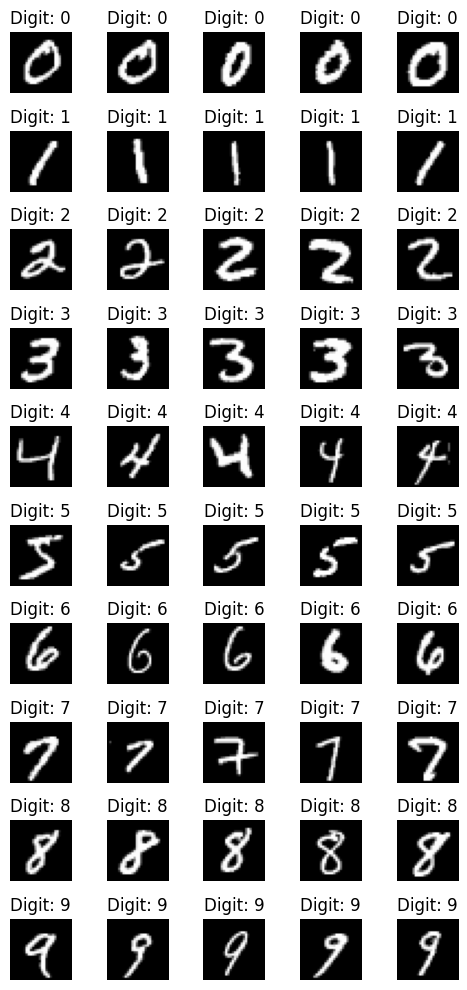

In [5]:
def plot_mnist_examples(examples_per_class=5):
    plt.figure(figsize=(5, 10))
    
    # Find examples of each digit (0-9)
    examples_by_digit = {i: [] for i in range(10)}
    
    # Get examples for each digit
    for img, label in train_dataset:
        if len(examples_by_digit[label]) < examples_per_class:
            examples_by_digit[label].append(img)
        
        # Check if we have enough examples for all digits
        if all(len(examples) == examples_per_class for examples in examples_by_digit.values()):
            break
    
    # Plot the examples
    for digit in range(10):
        for i, img in enumerate(examples_by_digit[digit]):
            plt.subplot(10, examples_per_class, digit * examples_per_class + i + 1)
            
            # Handle both tensor and PIL Image cases
            if isinstance(img, torch.Tensor):
                plt.imshow(img.squeeze().numpy(), cmap='gray')
            else:
                # Convert PIL Image to numpy array
                plt.imshow(np.array(img), cmap='gray')
                
            plt.title(f"Digit: {digit}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Call the function to plot examples
plot_mnist_examples()

For non-image data, it is a good idea to perform a Principal Component Analysis next, whcih will tell you which features are most important. Also, computing the feature correlation matrix can be helpful to understand which features are correlated. For images, this makes less sense, so we skip it.

But we should normalize our data such that it has zero mean and unit variance. To do this, we simply compute the mean of all features in the training set, subtract it from each data point (i.e., each image), compute the variance, and divide by it. There are many libraries that do this for you, and I usualy use sklearn.preprocessing.StandardScaler(). For the purpose of this notebook, we code it by hand, to show what is going on.

In [6]:
# find the mean and std
mean = train_data.to(torch.float32).mean()
std = train_data.to(torch.float32).std()
print(f"(mean, std) = ({mean:.4f}, {std:.4f})")

# standardize
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

# the CNN will expect images of the form [batch_size, channels, height, width]. Our images are grayscale, i.e., have only one channel, but we need to add a channel dimension anyways
train_data_reshaped = train_data.unsqueeze(1)
test_data_reshaped = test_data.unsqueeze(1)
print(f"New shapes: {train_data_reshaped.shape}, {test_data_reshaped.shape}")

# The loader will automatically provide mini-batches of the specified size, and shuffle after each epoch (we don't need to shuffle the test set).
# We need to make sure that the labels stay with the corresponding features. To do so, we create a tensor dataset first.
train_tensor = TensorDataset(train_data_reshaped.to(device), train_labels.to(device))
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

test_tensor = TensorDataset(test_data_reshaped.to(device), test_labels.to(device))
test_loader = DataLoader(test_tensor, batch_size=1000, shuffle=False)

(mean, std) = (33.3184, 78.5675)
New shapes: torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28])


## 3. Define the NN

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: 1 input channel (grayscale), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Second convolutional layer: 32 input channels, 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Max pooling layer with 2x2 kernel
        self.pool = nn.MaxPool2d(2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After 2 pooling layers image is 7x7
        self.fc2 = nn.Linear(128, 10)          # 10 output classes (digits 0-9)
        self.dropout = nn.Dropout(0.25)        # Dropout for regularization
    
    def forward(self, x):
        # First conv layer with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Second conv layer with ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the tensor
        x = x.view(-1, 64 * 7 * 7)
        # First fully connected layer with ReLU and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # Output layer
        x = self.fc2(x)
        return x


In [9]:
# Instantiate the model
model = SimpleCNN().to(device)

# optional but recommended: look at the model
import torchsummary
torchsummary.summary(model, input_size=train_data_reshaped.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


## 4. Train the NN

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Train the model
# usually, you would probably want more and nice output and track accuracies instead of losses
# But I keep it simple to not obscure the training steps with book-keeping of losses and outputs...
def train_model(model, train_loader, test_loader, epochs=5):
    # To track training progress
    training_history = {
        'train_loss': [],
        'test_loss': []
    }
    
    for epoch in range(epochs):
        model.train()  # set into training mode, activates dropouts for example.
        epoch_train_loss = 0
        
        # Training loop
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Track train loss
            epoch_train_loss += loss.item()
        
        epoch_train_loss /= len(train_loader)
        training_history['train_loss'].append(epoch_train_loss)
        
        # Evaluate on test set
        model.eval()  # set into eval mode, deactivates dropouts for example.
        epoch_test_loss = 0
        for i, (inputs, labels) in enumerate(test_loader):
            # no backward pass or optimization step for test!
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()
        
        epoch_test_loss /= len(test_loader)
        training_history['test_loss'].append(epoch_test_loss)
        
        print(f"Epoch {epoch+1:2d}: Train loss: {epoch_train_loss:.4f}, Test loss: {epoch_test_loss:.4f}")
    
    return model, training_history

In [17]:
# Train the model
model, hist = train_model(model, train_loader, test_loader, epochs=10)

Epoch   1: Train loss: 0.0038, Test loss: 0.0376
Epoch   2: Train loss: 0.0052, Test loss: 0.0500
Epoch   3: Train loss: 0.0053, Test loss: 0.0460
Epoch   4: Train loss: 0.0041, Test loss: 0.0475
Epoch   5: Train loss: 0.0050, Test loss: 0.0544
Epoch   6: Train loss: 0.0048, Test loss: 0.0460
Epoch   7: Train loss: 0.0043, Test loss: 0.0462
Epoch   8: Train loss: 0.0035, Test loss: 0.0438
Epoch   9: Train loss: 0.0046, Test loss: 0.0553
Epoch  10: Train loss: 0.0053, Test loss: 0.0386


plot the train and test loss

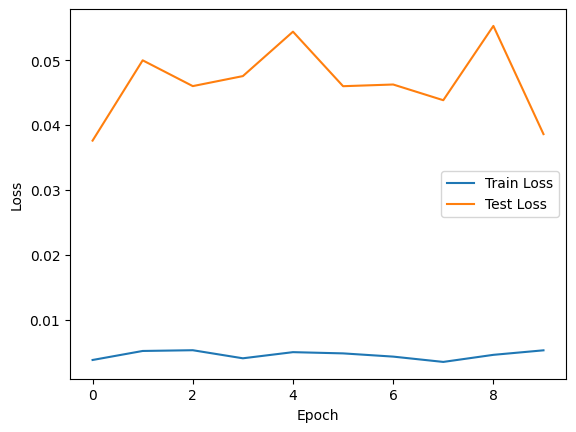

In [18]:
plt.plot(hist['train_loss'], label='Train Loss');
plt.plot(hist['test_loss'], label='Test Loss');
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.legend();

In [20]:
# Now we look at accuracies
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # use max probability to assigne a class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

train_acc, test_acc = evaluate_model(model, train_loader), evaluate_model(model, test_loader)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 99.9733, Test acc: 99.2500


## 5. Look at misclassifications and confusion matrix

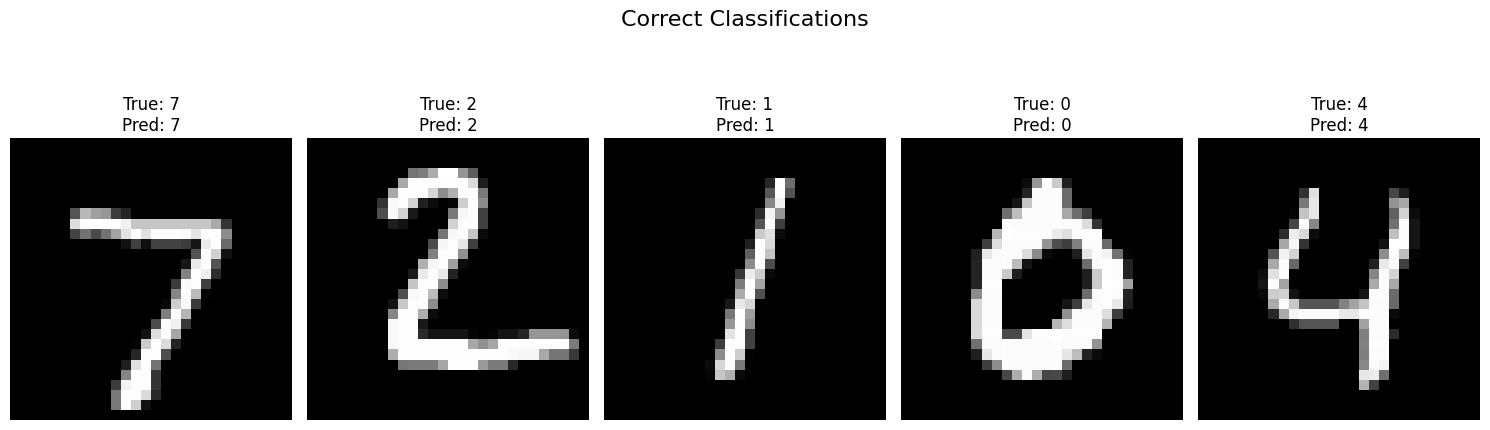

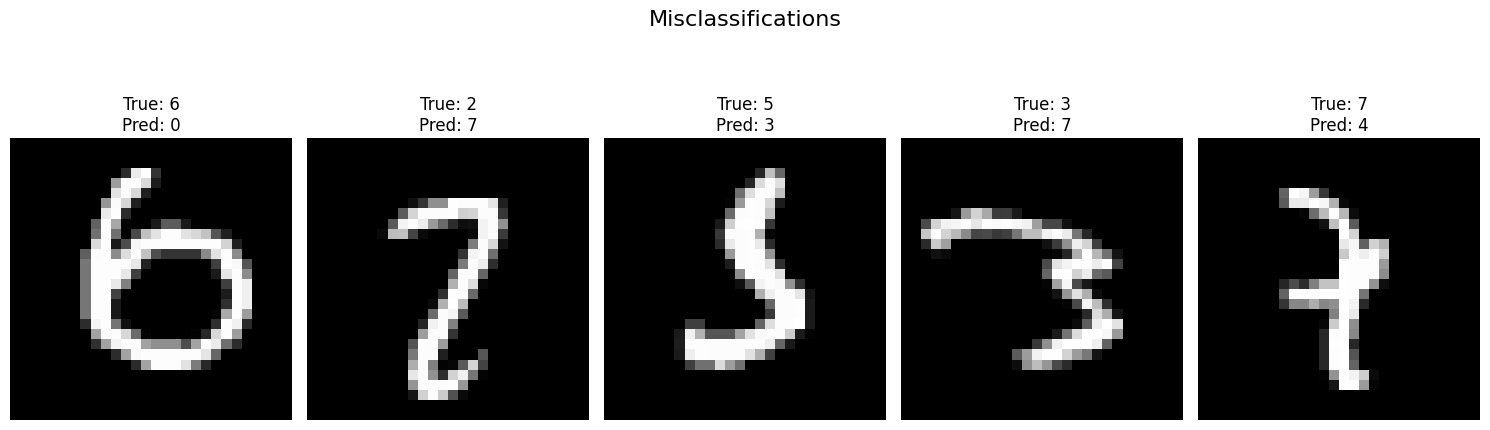


Let's look at some aggregate statistics:
Confusion Matrix:
tensor([[ 978,    0,    0,    0,    0,    0,    0,    0,    1,    1],
        [   0, 1131,    0,    2,    0,    0,    0,    2,    0,    0],
        [   2,    1, 1023,    1,    0,    0,    0,    2,    3,    0],
        [   0,    0,    0, 1006,    0,    2,    0,    1,    1,    0],
        [   0,    0,    0,    0,  975,    0,    0,    1,    1,    5],
        [   2,    0,    0,    5,    0,  881,    2,    1,    0,    1],
        [   4,    2,    0,    0,    2,    1,  949,    0,    0,    0],
        [   0,    3,    5,    0,    1,    0,    0, 1016,    1,    2],
        [   2,    0,    1,    1,    0,    0,    1,    0,  969,    0],
        [   0,    0,    0,    0,    5,    2,    0,    2,    3,  997]],
       dtype=torch.int32)

Accuracy for each class:
Digit 0: 99.80%
Digit 1: 99.65%
Digit 2: 99.13%
Digit 3: 99.60%
Digit 4: 99.29%
Digit 5: 98.77%
Digit 6: 99.06%
Digit 7: 98.83%
Digit 8: 99.49%
Digit 9: 98.81%


In [22]:
def show_predictions():
    model.eval()
    
    # Get a batch from the test loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Find some correct and incorrect predictions
    correct_indices = (predicted == labels).nonzero(as_tuple=True)[0]
    incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
    
    # Convert tensors back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    
    # Plot correct predictions
    plt.figure(figsize=(15, 5))
    plt.suptitle("Correct Classifications", fontsize=16)
    
    for i in range(5):
        if i < len(correct_indices):
            idx = correct_indices[i]
            plt.subplot(1, 5, i+1)
            plt.imshow(images[idx].squeeze().numpy(), cmap='gray')
            plt.title(f"True: {labels[idx]}\nPred: {predicted[idx]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Plot incorrect predictions (misclassifications)
    plt.figure(figsize=(15, 5))
    plt.suptitle("Misclassifications", fontsize=16)
    
    for i in range(5):
        if i < len(incorrect_indices):
            idx = incorrect_indices[i]
            plt.subplot(1, 5, i+1)
            plt.imshow(images[idx].squeeze().numpy(), cmap='gray')
            plt.title(f"True: {labels[idx]}\nPred: {predicted[idx]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Print confusion matrix
    print("\nLet's look at some aggregate statistics:")
    conf_matrix = torch.zeros(10, 10, dtype=torch.int)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                conf_matrix[labels[i], predicted[i]] += 1
    
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Calculate per-class accuracy
    class_accuracy = 100 * conf_matrix.diag() / conf_matrix.sum(1)
    print("\nAccuracy for each class:")
    for i in range(10):
        print(f'Digit {i}: {class_accuracy[i]:.2f}%')

# Show predictions and misclassifications
show_predictions()

# Now it's your turn

I list some suggestions of what you could do below. Pick the one (or ones) that intrest you the most, or just play with the notebook and investigate your own questions.

## Ex 1: Play with the CNN:
* Implement skip connections
* visualize the filter weights to see what the NN learned

## Ex 2: Write a CNN that classifies the fashion MNIST dataset

Implement your own classifier for Fashion MNIST, which is MNIST with fashion items instead of handwritten digits.

In [27]:
# You can download the dataset again from torchvision.datasets
import torchvision

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True
)

train_data, train_labels = train_dataset.data, train_dataset.targets

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True
)
test_data, test_labels = test_dataset.data, test_dataset.targets

print(train_data.shape, test_data.shape)

# check that the corresponding labels match
print(train_labels.shape, test_labels.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])
